# Grid SINDy
This notebook applies the time series SINDy approach but also splits the data by distance along the cable as well. This way we end up with rectangles that SINDy is analyzing in case we want to ingore / isolate certain anomolies within the cable.

In [7]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import random
import scipy
from scipy.integrate import odeint
from scipy.integrate import ode, complex_ode
from scipy.optimize import minimize
from findiff import FinDiff
import matplotlib.pyplot as plt
from time import perf_counter
from skimage import feature
from sklearn.metrics import r2_score
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyaC
import get_temp_amplitude
import lmfit
from tg_solver import tg_solve
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary, FourierLibrary
from pysindy.optimizers import STLSQ
from pysindy.feature_library import CustomLibrary
from DTS_to_displacement import DTS_to_disp, get_coefs

# import cv2

# matplotlib.use('TkAgg')
%matplotlib widget

# Set up data

In [8]:
# Read temperature data
infile = '../data/DTS/temp_cal_valid_cable_rmnoise.csv'
df_temp = pd.read_csv(infile, index_col=0)
df_temp.columns = pd.to_datetime(df_temp.columns)
df_temp.head()

2023-08-09 17:09:32.415  2023-08-09 17:14:32.521  \
-22.999                  21.8724                  21.9242   
-22.745                  21.8849                  21.9424   
-22.490                  21.8829                  21.9581   
-22.236                  21.9095                  21.9571   
-21.982                  21.9441                  21.9227   

         2023-08-09 17:19:32.622  2023-08-09 17:24:32.751  \
-22.999                  21.7593                  22.0574   
-22.745                  21.7415                  22.0645   
-22.490                  21.7719                  22.0786   
-22.236                  21.7812                  22.0970   
-21.982                  21.7831                  22.0871   

         2023-08-09 17:29:32.871  2023-08-09 17:34:33.023  \
-22.999                  22.2256                  22.5217   
-22.745                  22.2294                  22.5077   
-22.490                  22.2661                  22.4844   
-22.236                  22.2612                  22.4886   
-21.982                  22.2620                  22.5016   

         2023-08-09 17:39:33.151  2023-08-09 17:44:33.281  \
-22.999                  22.7067                  22.8808   
-22.745                  22.7098                  22.8978   
-22.490                  22.7420                  22.8877   
-22.236                  22.7592                  22.8818   
-21.982                  22.7392                  22.8826   

         2023-08-09 17:49:33.393  2023-08-09 17:54:33.510  ...  \
-22.999                  23.2244                  23.5173  ...   
-22.745                  23.2494                  23.5068  ...   
-22.490                  23.2459                  23.5008  ...   
-22.236                  23.2265                  23.4932  ...   
-21.982                  23.2373                  23.5235  ...   

         2023-08-29 13:21:53.278  2023-08-29 13:26:53.872  \
-22.999                  25.5453                  25.3991   
-22.745                  25.5339                  25.4029   
-22.490                  25.5144                  25.4283   
-22.236                  25.5312                  25.4563   
-21.982                  25.5722                  25.4460   

         2023-08-29 13:31:54.456  2023-08-29 13:36:55.019  \
-22.999                  25.4547                  25.4546   
-22.745                  25.4845                  25.4733   
-22.490                  25.4984                  25.5012   
-22.236                  25.5038                  25.5070   
-21.982                  25.5155                  25.5173   

         2023-08-29 13:41:55.583  2023-08-29 13:46:56.141  \
-22.999                  25.6803                  25.7883   
-22.745                  25.6727                  25.8092   
-22.490                  25.6936                  25.8112   
-22.236                  25.7078                  25.7885   
-21.982                  25.7258                  25.8020   

         2023-08-29 13:51:56.718  2023-08-29 13:56:57.291  \
-22.999                  25.9772                  25.8514   
-22.745                  25.9818                  25.8577   
-22.490                  25.9707                  25.8581   
-22.236                  25.9619                  25.8641   
-21.982                  25.9593                  25.8840   

         2023-08-29 14:01:57.900  2023-08-29 14:02:08.202  
-22.999                  25.8928                  26.1549  
-22.745                  25.9044                  26.1569  
-22.490                  25.9104                  26.0933  
-22.236                  25.9341                  26.1819  
-21.982                  25.9210                  26.2319  

[5 rows x 5715 columns]

In [9]:
# Put temperature data, optical distances and sampling times into numpy arrays
temp_arr = df_temp.to_numpy().T # we want to have the time to be in the 0-axis to be consistent with DAS data
times = pd.to_datetime(df_temp.columns)
dists = df_temp.index.to_numpy()

In [10]:
# plot selected DTS data over time
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = datetime.datetime(2023,8,9)
end_time = datetime.datetime(2023,8,30)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = temp_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]


In [11]:
# filter = scipy.signal.butter(1, 0.0111, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate
# Band pass filter 
filtered_arr = scipy.ndimage.gaussian_filter(plot_arr, 10, axes=1)

startt = start_time # datetime.datetime(2023, 8, 24, 16) # 25
endt = end_time # datetime.datetime(2023, 8, 26, 18) # 25
startind_t = np.absolute(plot_times - startt).argmin()
endind_t = np.absolute(plot_times - endt).argmin()

# startind_d = np.absolute(plot_dists - 2940).argmin()
# endind_d = np.absolute(plot_dists - 3000).argmin()

startind_d = np.absolute(plot_dists - 2900).argmin()
endind_d = np.absolute(plot_dists - 3300).argmin()

filtered_arr = scipy.ndimage.gaussian_filter(filtered_arr[startind_t:endind_t, startind_d:endind_d], 1.2)
# for i in range(len(filtered_arr[0, :])): filtered_arr[:, i] = filtered_arr[:, i] - filtered_arr[0, i]
plot_times_zoomed = plot_times[startind_t:endind_t]
plot_times_zoomed_int = plot_times_zoomed.astype('int64')
plot_dists_zoomed = plot_dists[startind_d:endind_d]

# Detecting the amplitude of the waves

## Making my own contours

In [32]:
disps_interp, depths_interp = DTS_to_disp(200, filtered_arr, plot_times_zoomed, plot_dists_zoomed)

  0%|          | 0/200 [00:00<?, ?it/s]/Users/eric/Desktop/UW_Lab_Work/for_Eric/notebooks/DTS_to_displacement.py:57: RuntimeWarning: All-NaN slice encountered
  if(j < median_sub_window): avg_depth = np.nanmedian(contour_points_arr[i, 0:(j+median_sub_window)])
/Users/eric/Desktop/UW_Lab_Work/for_Eric/notebooks/DTS_to_displacement.py:59: RuntimeWarning: All-NaN slice encountered
  else: avg_depth = np.nanmedian(contour_points_arr[i, (j-median_sub_window):(j+median_sub_window)])
100%|██████████| 200/200 [00:14<00:00, 14.13it/s]


In [33]:
## Normalize disps_interp ## 
disps_interp = (disps_interp - np.min(disps_interp)) / (np.max(disps_interp) - np.min(disps_interp))
disps_interp = 2 * disps_interp - 1

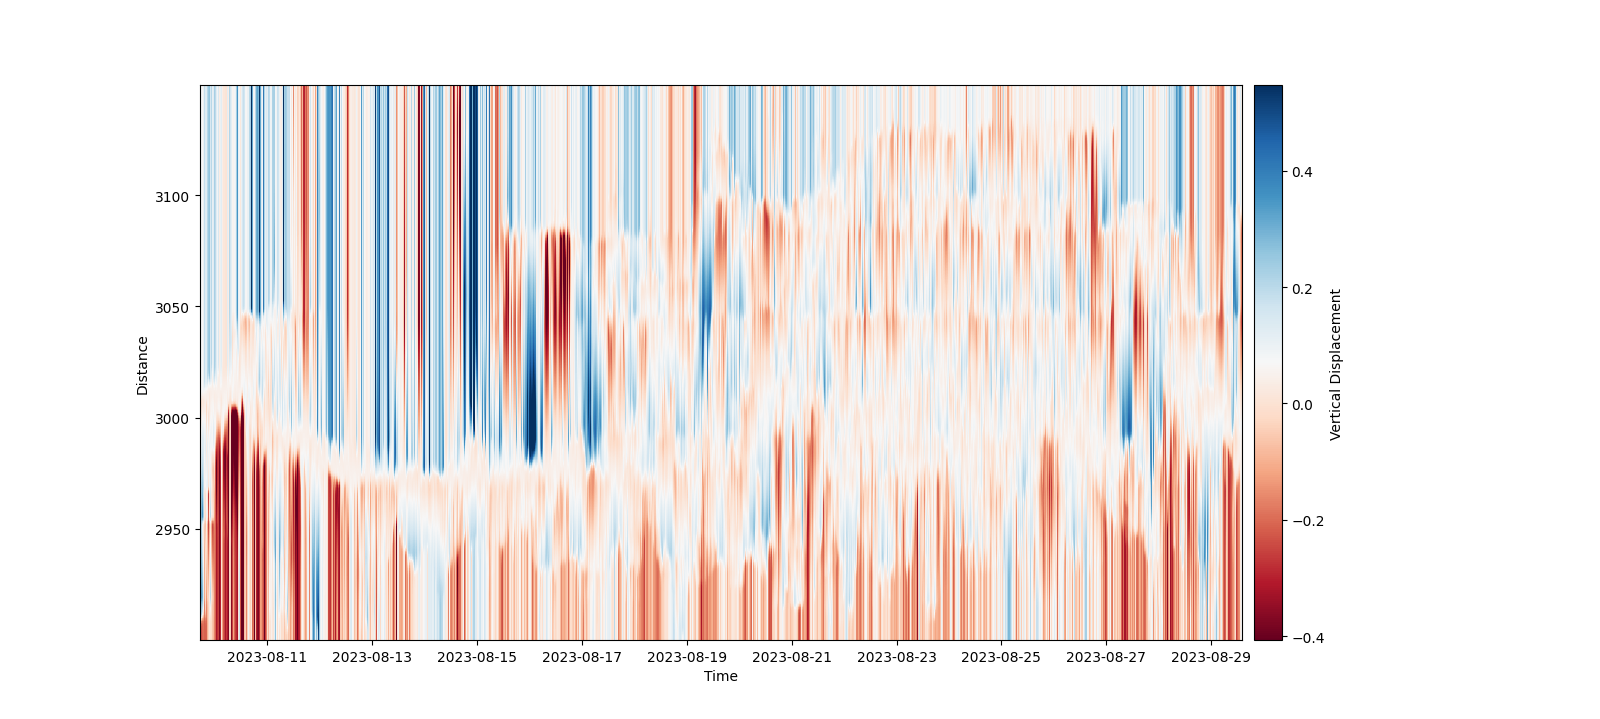

In [34]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# for i in range(len(disps_interp[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + disps_interp[i, :])
ddt = np.gradient(disps_interp, axis=1)
im1 = ax.imshow(disps_interp, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='RdBu',
            vmin=np.percentile(disps_interp[~np.isnan(disps_interp)],1),
            vmax=np.percentile(disps_interp[~np.isnan(disps_interp)],99),
            )
ax.set_ylabel('Distance') 
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement')
plt.show()


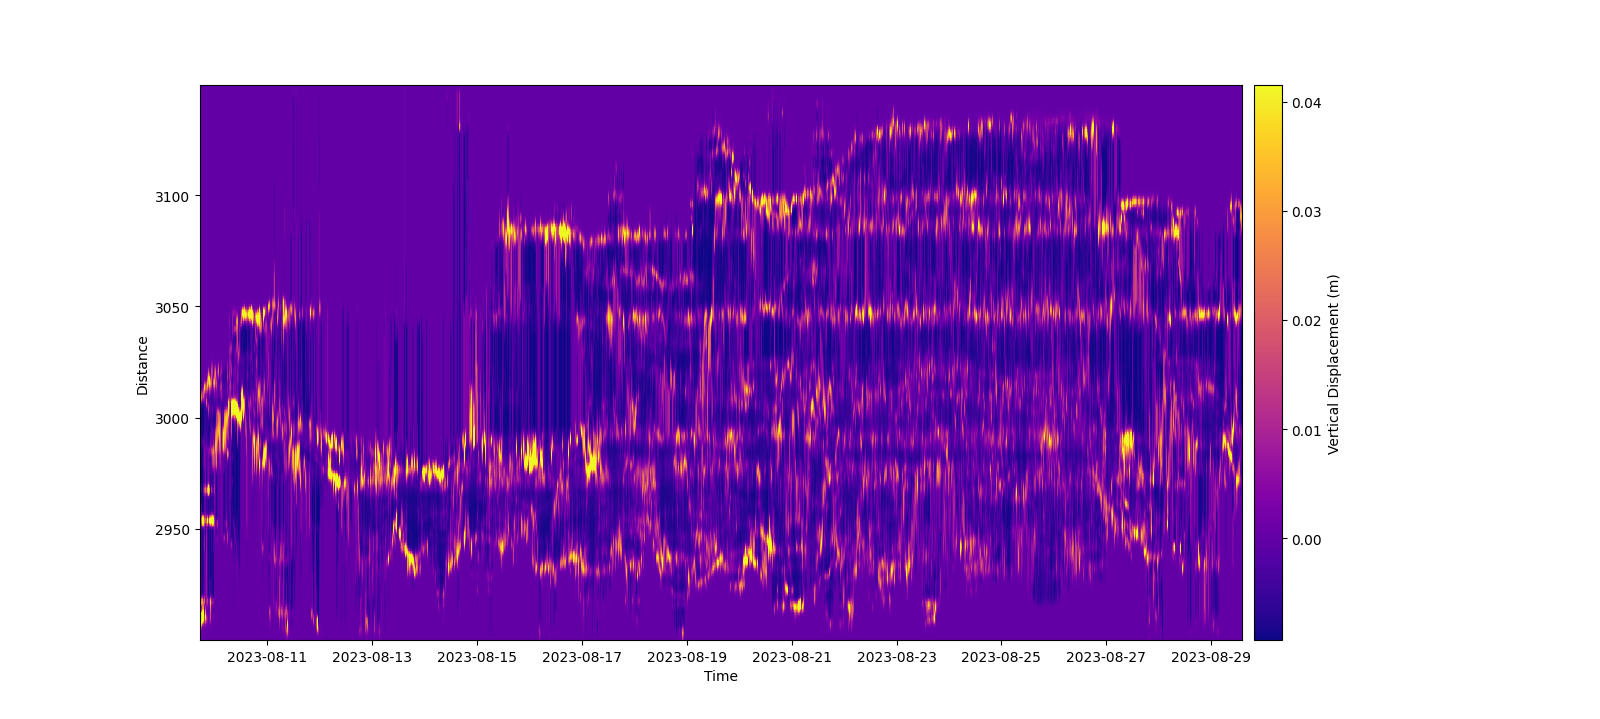

In [35]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
disps_interp = scipy.ndimage.gaussian_filter1d(disps_interp, 0.01) 
# for i in range(len(disps_interp[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + disps_interp[i, :])
ddt = np.gradient(disps_interp, axis=0)
ddtdt = np.gradient(ddt, axis=0)
im1 = ax.imshow(ddt, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(ddt[~np.isnan(ddt)],1),
            vmax=np.percentile(ddt[~np.isnan(ddt)],99),
            )
ax.set_ylabel('Distance') 
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement (m)')
plt.show()


## Temperature plotted data

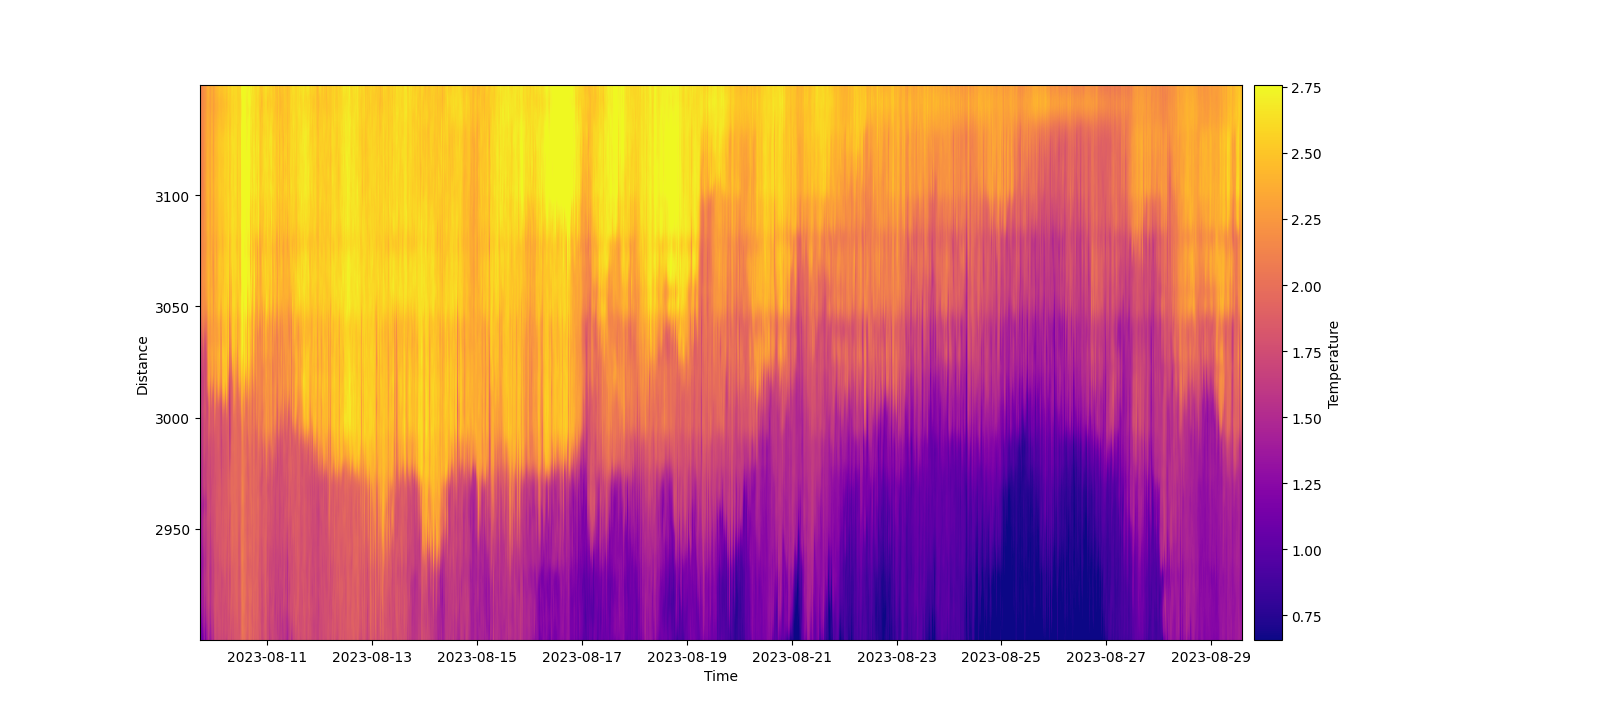

In [36]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
im1 = ax.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(filtered_arr[~np.isnan(filtered_arr)],1),
            vmax=np.percentile(filtered_arr[~np.isnan(filtered_arr)],99),
            )
# for i in range(len(contour_values)): plt.plot(plot_times_zoomed, contour_points_arr[i], '-')
# for i in range(len(contour_values)): plt.plot(contour_points[contour_values[i]]['t'], contour_points[contour_values[i]]['x'], '.')
# plt.contour(plot_times_zoomed, plot_dists_zoomed, filtered_arr.T, contour_values)

ax.set_ylabel('Distance')
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Temperature')
plt.show()

# Set up SINDy

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

## SINDy Stuff

## Trying with original method (not weak)

In [40]:
# Loop through the displacement grid and get the coefficents for each rectangular segment

t = np.array(plot_times_zoomed_int - plot_times_zoomed_int[0]) * 1.666e-11 # grid_x[:, 0]
x = depths_interp - depths_interp[0] # grid_y[0, :]
window_size_t = 30
window_size_x = 50
n_segments_t = int(len(t)/window_size_t) - 1
n_segments_x = int(len(x)/window_size_x) - 1
feature_names, temp_coef, score = get_coefs(x, t[0:100], disps_interp[:, 0:100], 4e-2)
coefficients = np.empty((len(temp_coef), n_segments_t, n_segments_x))
segment_t = [0] * n_segments_t
segment_x = [0] * n_segments_x
sparsity = 2e-3
scores = np.empty((n_segments_t, n_segments_x))

for i in tqdm(range(n_segments_t)):
    for j in range(n_segments_x):
        start_t_ind = i * window_size_t
        end_t_ind = (i+1)* window_size_t
        start_x_ind = j * window_size_x
        end_x_ind = (j+1) * window_size_x
        if(end_t_ind > len(t) - 1): end_t_ind = len(t) - 1
        if(end_x_ind > len(x) - 1): end_x_ind = len(x) - 1
        segment_t[i] = plot_times_zoomed[int((start_t_ind + end_t_ind)/2)]
        segment_x[j] = depths_interp[int((start_x_ind + end_x_ind)/2)]

        feature_names, coefficients[:, i, j], score = get_coefs(x[start_x_ind:end_x_ind], t[start_t_ind:end_t_ind], disps_interp[start_x_ind:end_x_ind, start_t_ind:end_t_ind], sparsity)
        # coefficients[:, i, j] = np.array([x if(x <= 1e4 and x >= -1e4 ) else 0 for x in coefficients[:, i]])
        scores[i] = score
print(feature_names)

100%|██████████| 189/189 [00:23<00:00,  8.10it/s]

['1', 'u', '(du/dt)', 'uu', '(du/dt)(du/dt)', 'u(du/dt)', 'u_1', '(du/dt)_1', 'u_11', '(du/dt)_11', 'uu_1', 'u(du/dt)_1', '(du/dt)u_1', '(du/dt)(du/dt)_1', 'uuu_1', 'uu(du/dt)_1', '(du/dt)(du/dt)u_1', '(du/dt)(du/dt)(du/dt)_1', 'u(du/dt)u_1', 'u(du/dt)(du/dt)_1', 'uu_11', 'u(du/dt)_11', '(du/dt)u_11', '(du/dt)(du/dt)_11', 'uuu_11', 'uu(du/dt)_11', '(du/dt)(du/dt)u_11', '(du/dt)(du/dt)(du/dt)_11', 'u(du/dt)u_11', 'u(du/dt)(du/dt)_11']


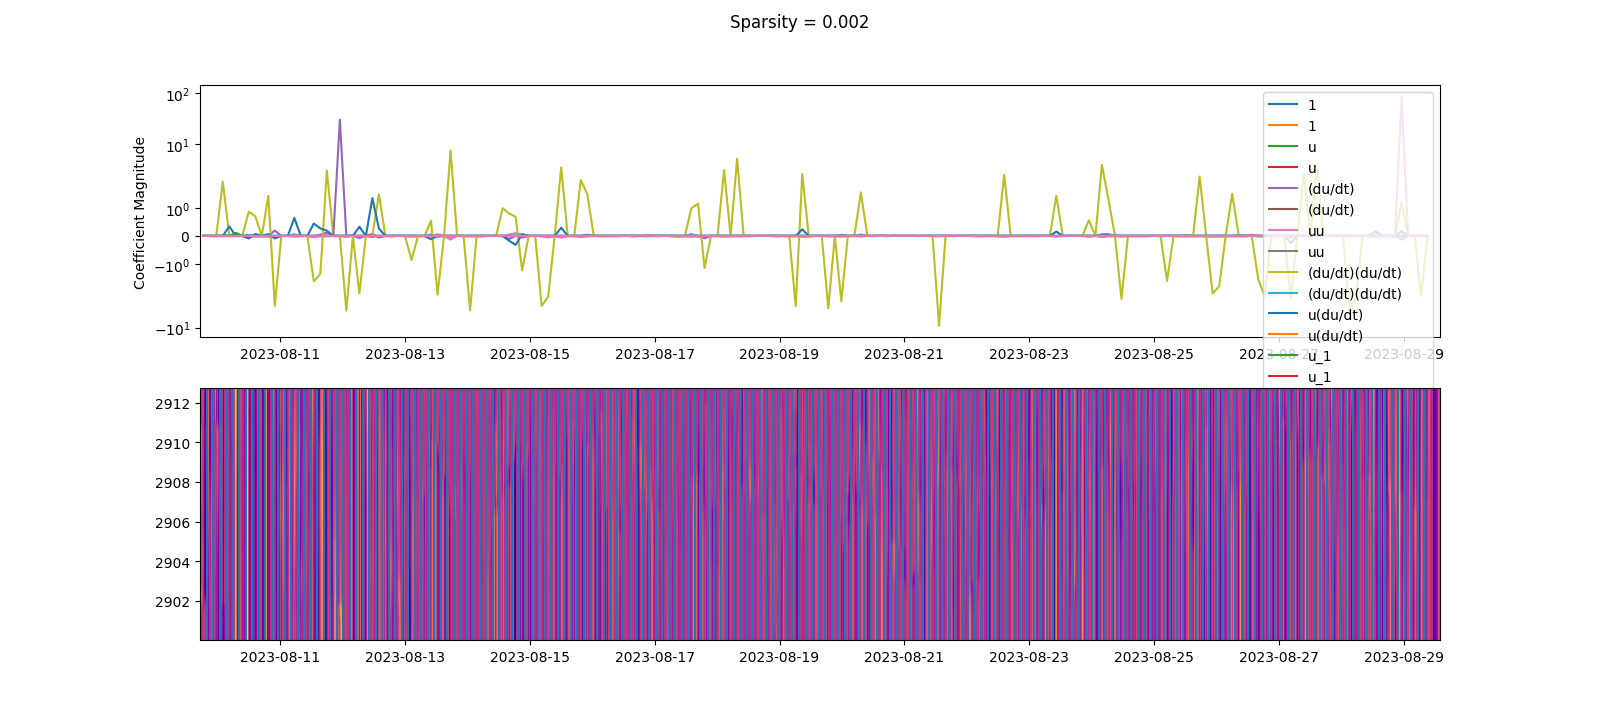

In [41]:
fig, ax = plt.subplots(2, figsize=(2.5*6.4,1.5*4.8))
dist_slice = 0
for i in range(len(feature_names)): 
    if(np.mean(np.abs(coefficients[i, :, dist_slice])) > 0): ax[0].plot(segment_t, coefficients[i, :, dist_slice], 0.1, '-', label=feature_names[i])
# i = 1
# plt.plot(segment_t, np.abs(coefficients[i, :]), '-', label=feature_names[i])
fig.suptitle("Sparsity = " + str(sparsity))
# plt.xlim(segment_t[0], segment_t[-1])
ax[0].set_yscale('symlog')
ax[0].set_ylabel('Coefficient Magnitude')
ax[0].set_xlim([plot_times_zoomed[0], plot_times_zoomed[-1]])
ax[0].legend()

im1 = ax[1].imshow(disps_interp[dist_slice*window_size_x:(dist_slice + 1)*window_size_x, :], origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[dist_slice*window_size_x], plot_dists_zoomed[(dist_slice + 1)*window_size_x]],
            cmap='plasma',
            vmin=np.percentile(disps_interp[~np.isnan(disps_interp)],1),
            vmax=np.percentile(disps_interp[~np.isnan(disps_interp)],99),
            )

ax[1].vlines(plot_times_zoomed[np.arange(0, n_segments_t) * window_size_t], plot_dists_zoomed[dist_slice*window_size_x], plot_dists_zoomed[(dist_slice + 1)*window_size_x])

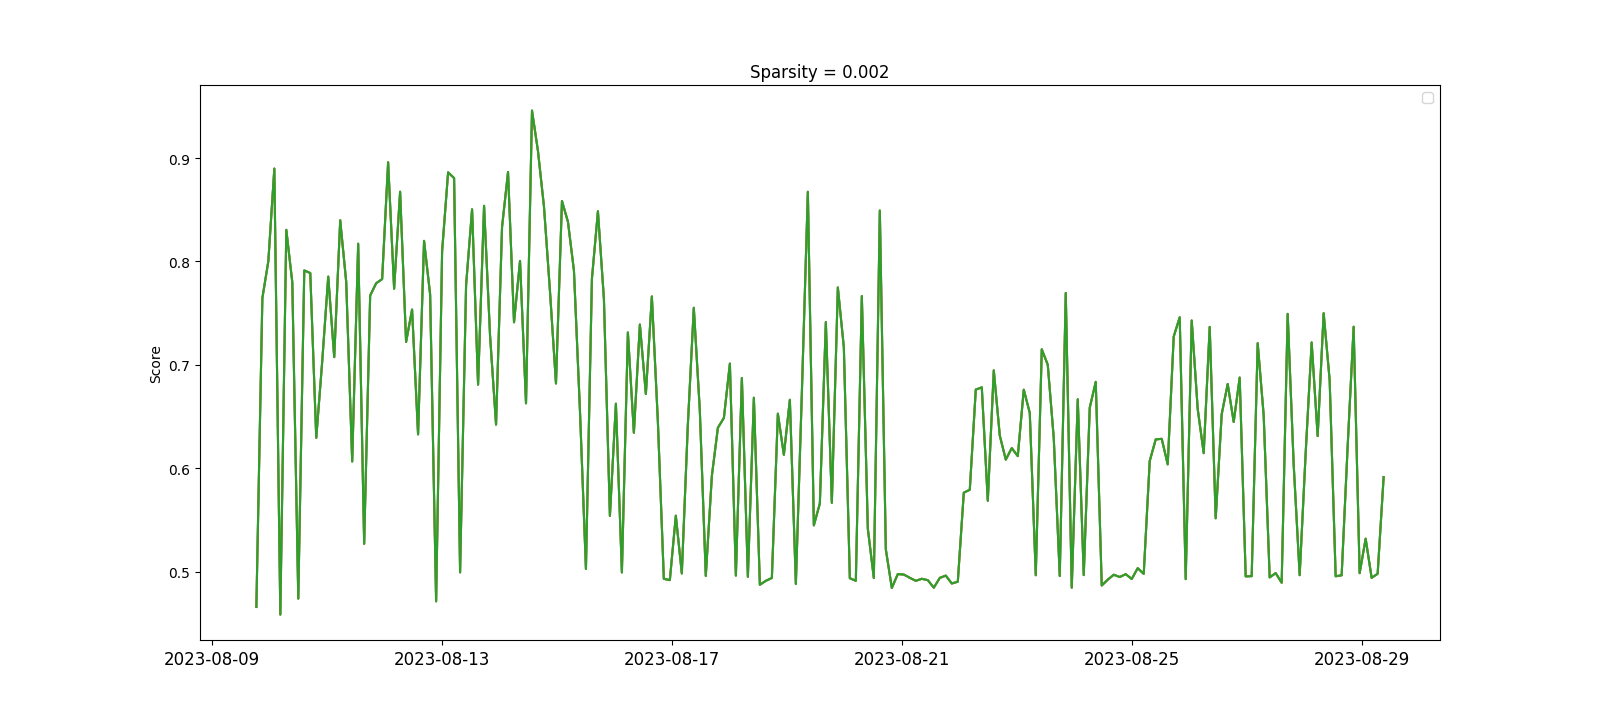

In [42]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
plt.plot(segment_t, scores)
# i = 1
# plt.plot(segment_t, np.abs(coefficients[i, :]), '-', label=feature_names[i])
plt.title("Sparsity = " + str(sparsity))
plt.xticks(fontsize=12)
# plt.xlim(segment_t[0], segment_t[-1])
# plt.ylim([-1e-1, 1e-1])
plt.ylabel("Score")
plt.legend()